# DTSA-5510,  Final: Genre classification from song lyrics
### October 3, 2023


This jupyter notebok is uploaded to https://github.com/daisukexp/dtsa5510_final

In [69]:
import sys
import platform
import os
import warnings

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import time

import string
import nltk
#nltk.download('punkt')

import re

from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

#warnings.simplefilter(action = 'ignore', category = FutureWarning)
#warnings.simplefilter(action = 'ignore', category = Warning)

In [3]:
sys.version

'3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]'

# Step 1 : Gather data, determine the method of data collection and provenance of the data

### Introduction
In this final project, I sought a theme related to my life or hobbies. Given that music is a perennial presence in my life, I explored topics related to it. I chose to work with a dataset that could aid in predicting music genres from song lyrics. Classification is a prevalent field in unsupervised learning.

### About Dataset

The dataset is sourced from Kaggle and is titled "Song Lyrics from 79 Musical Genres," accessible via the following link,

https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres/data

This dataset came from a desire for stretching my web scrapping skills as well as to trian a LSTM network to maybe compose some lyrics.

All the data were obtained by scraping the Brazilian website Vagalume using R.

There are two datasets artists-data.csv and lyrics-data.csv.

# Step 2 : Identify an Unsupervised Learning Problem

### Problem Definition
We aim to classify song genres based on their lyrics, utilizing the words and phrases unique to different artists. While this is fundamentally a supervised machine learning task, with many studies conducted using supervised or deep learning methods, our goal is different. We want to explore the potential of unsupervised learning for this task. If successfully creating a classification model without relying on labels offers significant advantages, it allows data scientists to utilize a broader variety of datasets in real-world applications without the need for labeled data.

### Approach & Methodology
Our methodology distinguishes itself from typical solutions found on platforms like Kaggle, which often focus primarily on visualizing dataset trends. Our approach is more holistic, encompassing the following elements:

- Build Multiple Models:
We plan to develop and test several unsupervised learning models. Our aim is to rigorously evaluate their performance in predicting genre classifications. By comparing the results, we can determine the most effective model for our purposes.

- Analysis:
Our analysis is multifaceted. In this project, we emphasize computational efficiency during model construction, in addition to prioritizing model accuracy. This dual focus ensures our model is not only precise but also performance-optimized. By adopting this approach, we aim to provide an effective solution to the challenge at hand.

# Step 3 : Exploratory Data Analysis(EDA) - Inspect, Visualize and Clean the Data


### Initial inspection  and cleaning

In [4]:
df_lyrics = pd.read_csv('data/lyrics-data.csv')

In [5]:
df_lyrics

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt
...,...,...,...,...,...
379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


In [6]:
df_artists = pd.read_csv('data/artists-data.csv')
df_artists

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/
...,...,...,...,...,...
4163,Miriam Makeba,World Music; Black Music; Blues,17.0,0.0,/miriam-makeba/
4164,Freddie Aguilar,World Music,61.0,0.0,/freddie-aguilar/
4165,Amadou & Mariam,World Music,14.0,0.0,/amadou-mariam/
4166,Magic System,World Music; Gospel/Religioso,16.0,0.0,/magic-system/


Drop unused fields and merge the lyrics with artist information. Retain only songs in English.

In [7]:
df_merged = pd.merge(df_lyrics, df_artists, left_on='ALink', right_on='Link')
df_merged = pd.merge(df_lyrics, df_artists, left_on='ALink', right_on='Link', how='outer')
df_merged.drop(columns=['ALink', 'Link', 'SLink', 'Songs'], inplace=True)
df_merged = df_merged[df_merged['language'] == 'en']
df_merged

,SName,Lyric,language,Artist,Genres,Popularity
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,Ivete Sangalo,Pop; Axé; Romântico,4.4
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,Ivete Sangalo,Pop; Axé; Romântico,4.4
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,Ivete Sangalo,Pop; Axé; Romântico,4.4
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,Ivete Sangalo,Pop; Axé; Romântico,4.4
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,Ivete Sangalo,Pop; Axé; Romântico,4.4
...,...,...,...,...,...,...
379926,The Waiting,Chorus\nHere we stand waiting on the plain\nDa...,en,Johnny Clegg,World Music; Gospel/Religioso,0.0
379927,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,en,Johnny Clegg,World Music; Gospel/Religioso,0.0
379928,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",en,Johnny Clegg,World Music; Gospel/Religioso,0.0
379929,When The System Has Fallen,Sweat in the heat for days on end\nwaiting for...,en,Johnny Clegg,World Music; Gospel/Religioso,0.0


Drop rows where the "Lyric" or "Genres" columns are missing.

In [8]:
df_merged.isna().sum()

SName           2
Lyric           0
language        0
Artist        427
Genres        436
Popularity    427
dtype: int64

In [9]:
df_merged = df_merged.dropna(subset=['Lyric', 'Genres'])

In [11]:
df_merged

,SName,Lyric,language,Artist,Genres,Popularity
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,Ivete Sangalo,Pop; Axé; Romântico,4.4
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,Ivete Sangalo,Pop; Axé; Romântico,4.4
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,Ivete Sangalo,Pop; Axé; Romântico,4.4
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,Ivete Sangalo,Pop; Axé; Romântico,4.4
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,Ivete Sangalo,Pop; Axé; Romântico,4.4
...,...,...,...,...,...,...
379926,The Waiting,Chorus\nHere we stand waiting on the plain\nDa...,en,Johnny Clegg,World Music; Gospel/Religioso,0.0
379927,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,en,Johnny Clegg,World Music; Gospel/Religioso,0.0
379928,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",en,Johnny Clegg,World Music; Gospel/Religioso,0.0
379929,When The System Has Fallen,Sweat in the heat for days on end\nwaiting for...,en,Johnny Clegg,World Music; Gospel/Religioso,0.0


We have 191378 English songs.

### Visualize

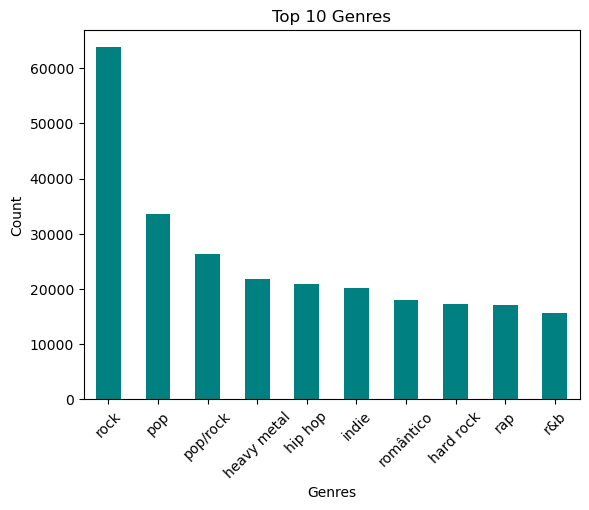

In [12]:
genres_split = df_merged['Genres'].str.lower().str.strip().str.split(';').explode().str.strip()
top_genres = genres_split.value_counts().head(10)

top_genres.plot(kind='bar', color='teal')
plt.title('Top 10 Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

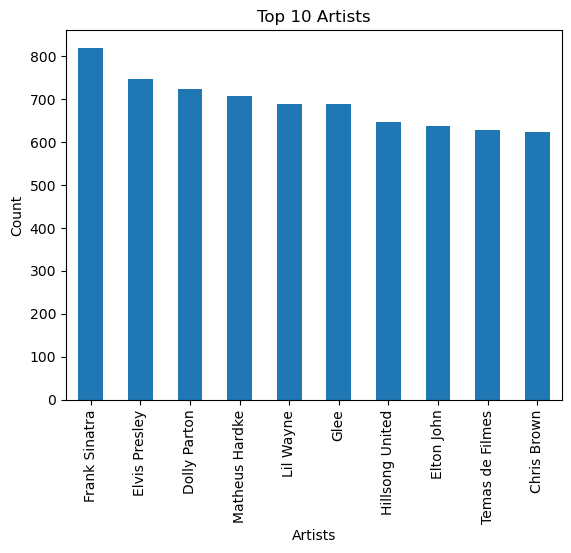

In [94]:
top_artists = df_merged['Artist'].value_counts().head(10)
top_artists.plot(kind='bar')
plt.title('Top 10 Artists')
plt.xlabel('Artists')
plt.ylabel('Count')
plt.show()

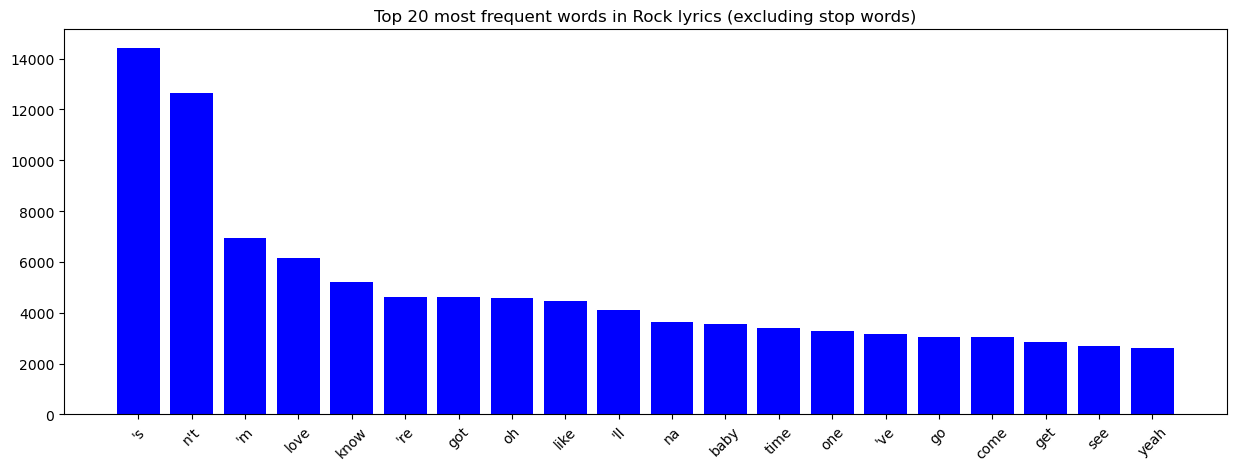

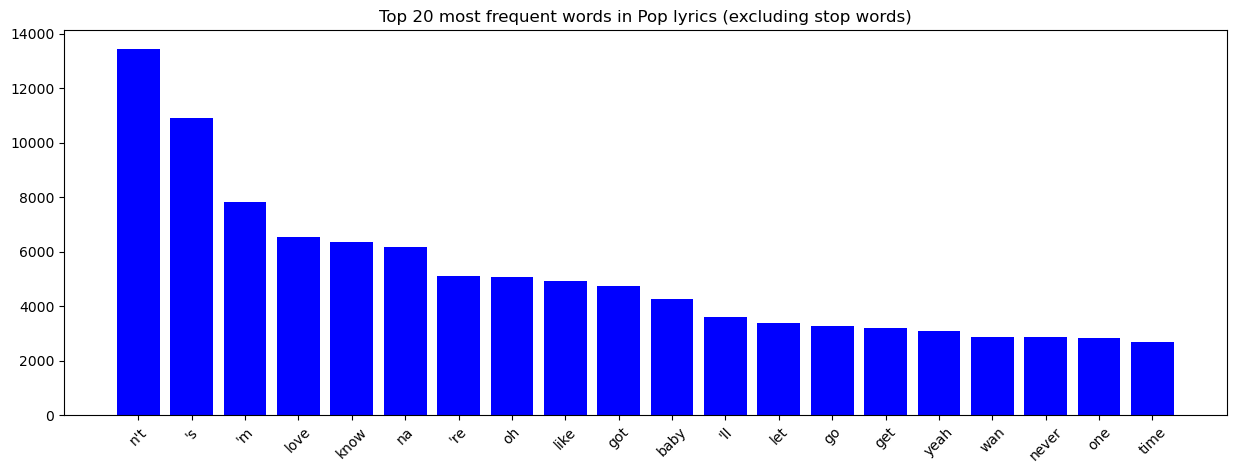

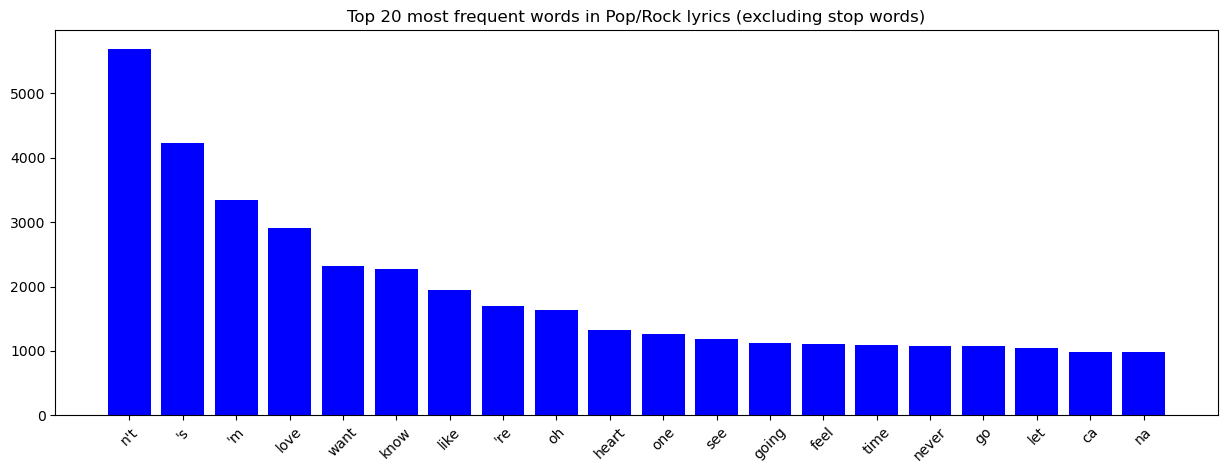

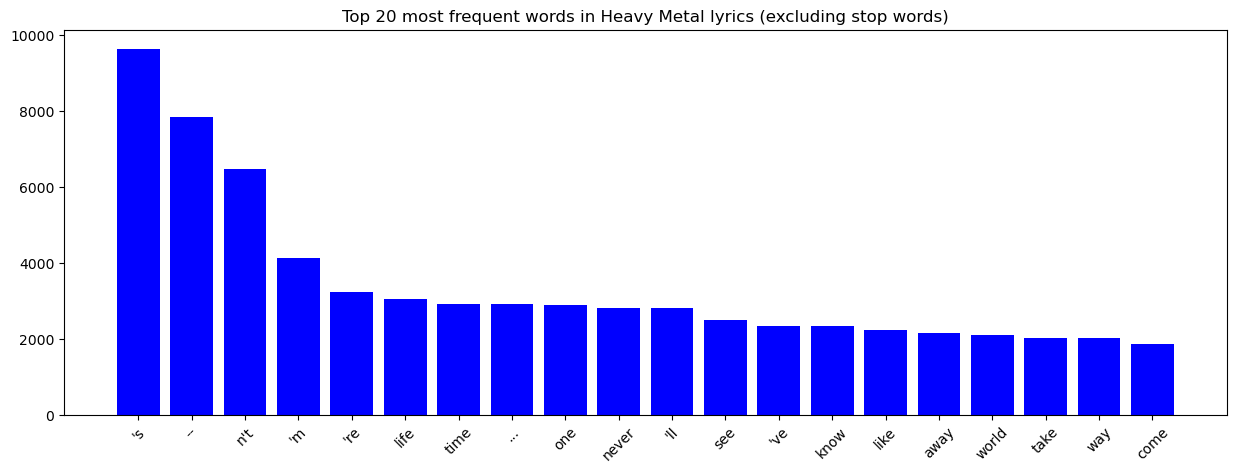

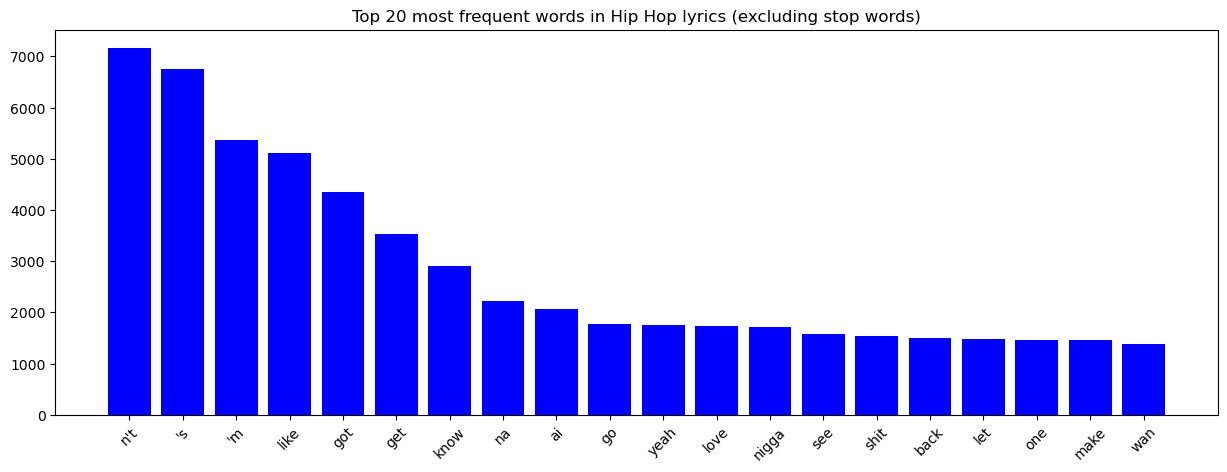

In [62]:
# Load English stop words
stop_words = set(stopwords.words('english'))

top_genres = ['Rock', 'Pop', 'Pop/Rock', 'Heavy Metal', 'Hip Hop']

# Function to preprocess and tokenize text
def tokenize(text):
    tokens = word_tokenize(text.lower())  # Convert text to lowercase and tokenize
    tokens = [t for t in tokens if t not in string.punctuation and t not in stop_words]  # Remove punctuation and stop words
    return tokens

# Loop through each genre and plot the top 20 most frequent words
for genre in top_genres:
    genre_df = df_merged[df_merged['Genres'] == genre]
    all_words = []
    
    for lyric in genre_df['Lyric']:
        all_words.extend(tokenize(lyric))
    
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)
    
    words, counts = zip(*common_words)
    plt.figure(figsize=(15, 5))
    plt.bar(words, counts, color='blue')
    plt.title(f"Top 20 most frequent words in {genre} lyrics (excluding stop words)")
    plt.xticks(rotation=45)
    plt.show()

We observed shared vocabularies across different genres, which aligns with general perceptions of song lyrics. Given this overlap, we anticipate lower accuracy for our classification model.

We'll now proceed to build our models and conduct analyses.

# Step 4 : Perform Analysis Using Unsupervised Learning Models of your Choice, Present Discussion, and Conclusions 

## 4.1 : Model Selection

In our endeavor to create a classification model for genres using lyrics, we opted for two distinct and widely-used unsupervised machine learning models: K-Means Clustering and DBSCAN. Our decision to choose these models was influenced by their reputation in managing diverse datasets, their performance metrics, and their adaptability to varied feature sets.

### K-Means Clustering
K-Means Clustering is a straightforward and prevalent clustering algorithm. For this method, the number of clusters must be specified in advance. To determine the optimal number of clusters, we computed the Silhouette scores. After selecting the appropriate number of clusters, we proceeded to build our classification model.

### DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering method that can discover clusters of different shapes and sizes from a large amount of data, this is an advantage to K-Means.

### K-Mean Clustring with data tuning
Given the vast number of genres in our dataset and the considerable computing time required, we decided on a data-tuning strategy. We selected the top 5 genres to assess whether the model could provide both robust classification performance and efficient use of computing resources.

## 4.2 K-Means Clustering

### Preprocessing
To determine the target number of clusters for our K-Means model, we calculated Silhouette scores.

For n_clusters = 2 The average silhouette_score is : 0.0023222606888545255
For n_clusters = 3 The average silhouette_score is : 0.0006292018015322125
For n_clusters = 4 The average silhouette_score is : 0.0007228172748481615
For n_clusters = 5 The average silhouette_score is : 0.0013616970891829087
For n_clusters = 6 The average silhouette_score is : 0.001678371368754905
For n_clusters = 7 The average silhouette_score is : 0.0019633390245159172
For n_clusters = 8 The average silhouette_score is : 0.002940798416085463
For n_clusters = 9 The average silhouette_score is : 0.0032903543116642744
For n_clusters = 10 The average silhouette_score is : 0.003461288664437112
For n_clusters = 11 The average silhouette_score is : 0.005424066622946752
For n_clusters = 12 The average silhouette_score is : 0.005769246622523865
For n_clusters = 13 The average silhouette_score is : 0.005929659940647182
For n_clusters = 14 The average silhouette_score is : 0.006028257486105614
For n_clusters = 15 The ave

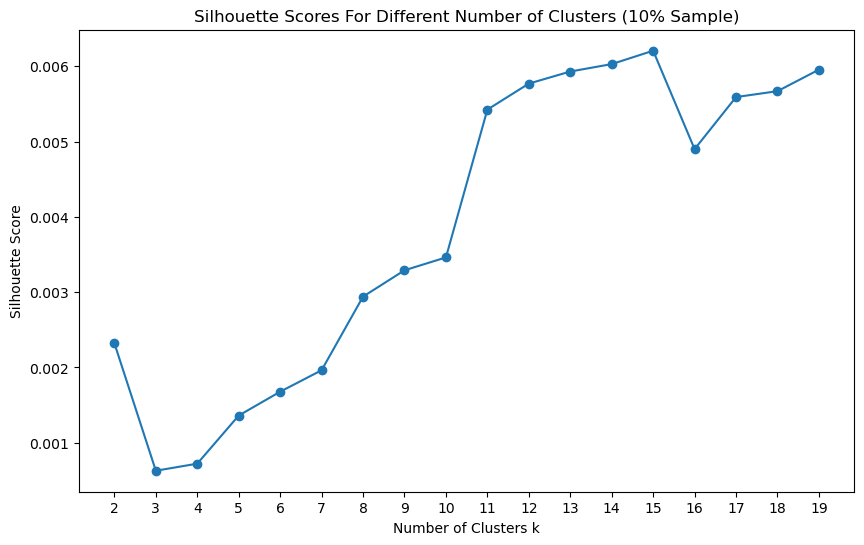

In [71]:
# Extracting a random 10% sample of the data
df_sampled, _ = train_test_split(df_merged, test_size=0.9, random_state=123)

# Vectorize the 'Lyric' column
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_sampled = vectorizer.fit_transform(df_sampled['Lyric'].fillna(''))

k_clusters = 20

silhouette_scores = []
range_n_clusters = list(range(2, k_clusters))

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, n_init='auto', random_state=123)
    cluster_labels = clusterer.fit_predict(X_sampled)
    
    silhouette_avg = silhouette_score(X_sampled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Plotting silhouette scores
plt.figure(figsize=(10,6))
plt.plot(range_n_clusters, silhouette_scores, '-o')
plt.title('Silhouette Scores For Different Number of Clusters (10% Sample)')
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.show()

The silhouette score gauges how similar an object is to its own cluster (cohesion) relative to other clusters (separation). This metric has a range from -1 to 1. A high silhouette score suggests that the object aligns well with its cluster and is distinct from other clusters.

Upon analyzing our silhouette scores, which are relatively close to 0, we infer that there is no distinct structure or separation in the data. This implies that the data points are situated very close to the decision boundaries of adjacent clusters.

The low silhouette scores and their minimal growth with an increase in cluster count suggest that using a significantly larger number of clusters might not yield any substantial benefits, especially when accounting for computational overheads.

Nevertheless, if we aim to experiment further with different cluster counts, we can certainly increase the number of clusters to observe any significant enhancements in the silhouette score. However, cluster count rises, the risk of overfitting the data also escalates.

We choose 15 for number of clusters allign with the highest silhouette score.

### Model training

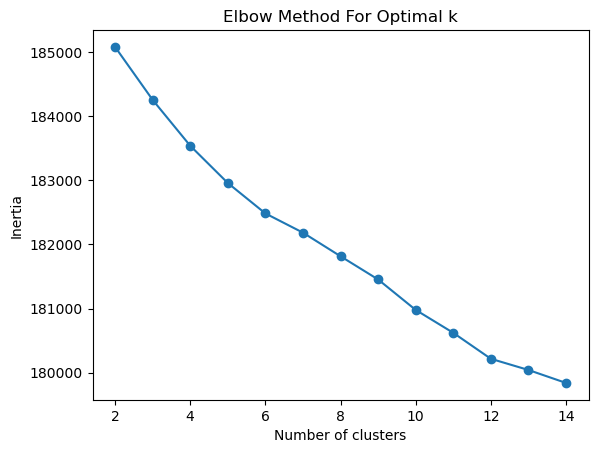

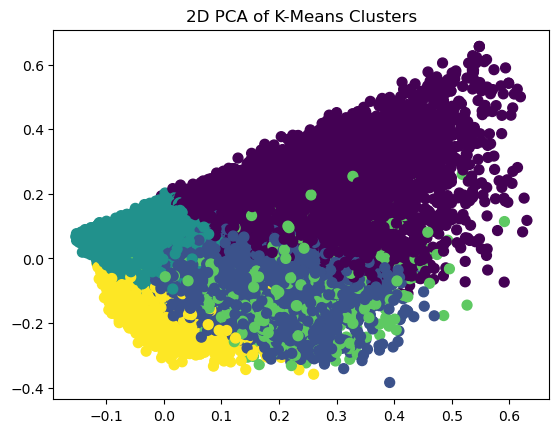

Time taken: 87.0 seconds


In [91]:
start_time = time.time()

k_clusters = 15

# Preprocessing
df_kmeans = df_merged.copy()
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df_merged['Lyric'])

inertia = []
range_clusters = range(2, k_clusters)
for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters,  n_init='auto', random_state=123)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

k_optimal = 5

# Clustering
kmeans = KMeans(n_clusters=k_optimal, random_state=123)
df_kmeans['Cluster'] = kmeans.fit_predict(X)

# Visualization
reduced_data = PCA(n_components=2).fit_transform(X.toarray())
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df_kmeans['Cluster'], cmap='viridis', s=50)
plt.title('2D PCA of K-Means Clusters')
plt.show()

# Calculate computing time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {round(elapsed_time, 1)} seconds")

## 4.3 DBSCAN

### Model training

Estimated number of clusters: 889
Estimated number of noise points: 182336


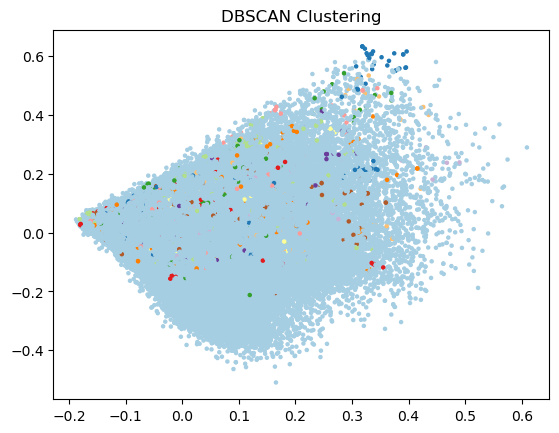

Time taken: 4247.5 seconds


In [73]:
start_time = time.time()

# Sample 10% of data
#df_dbscan, _ = train_test_split(df_merged, test_size=0.9, random_state=123)

# Full data
df_dbscan = df_merged.copy()

# Vectorize the 'Lyric' column
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_sampled_dbscan = vectorizer.fit_transform(df_dbscan['Lyric'].fillna(''))

# Scale Features
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_sampled_dbscan)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
labels = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the sampled DataFrame
df_dbscan['DBSCAN_Cluster'] = labels

# Print the number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

# Visualize the clusters in 2D space
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled.toarray())  # Convert to dense before applying PCA

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Paired', s=5)
plt.title('DBSCAN Clustering')
plt.show()

# Calculate computing time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {round(elapsed_time, 1)} seconds")

Upon visual inspection, it became evident that the DBSCAN model did not fit the dataset well, we observed the scattered clusters.

## 4.4 K-Means Clustering with data tuning

Given the variety of genres in the dataset, both K-Means and DBSCAN struggled to deliver satisfactory performance. To address this, we made a domain-specific adjustment by focusing on the top 5 genres. We then constructed a K-Means model with the number of clusters set to 5.

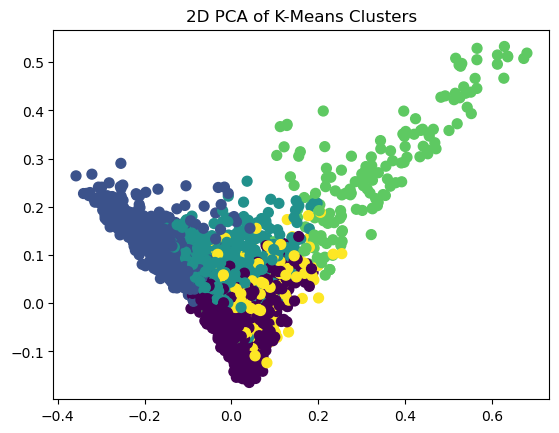

Time taken: 1.8 seconds


In [74]:
start_time = time.time()

top_genres = ['Rock', 'Pop', 'Pop/Rock', 'Heavy Metal', 'Hip Hop'] 
min_samples = min(df_merged[df_merged['Genres'].isin(top_genres)].groupby('Genres').size())
df_balanced = pd.DataFrame()

for genre in top_genres:
    df_genre = df_merged[df_merged['Genres'] == genre]
    if not genre_df.empty:
        df_balanced = pd.concat([df_balanced, df_genre.sample(n=min_samples, random_state=123)], ignore_index=True)

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))  # unigrams and bigrams
X_filtered = vectorizer.fit_transform(df_balanced['Lyric'].fillna(''))

n_clusters_adj = 5
kmeans = KMeans(n_clusters=n_clusters_adj, n_init='auto', random_state=123)
df_balanced['Cluster'] = kmeans.fit_predict(X_filtered)

reduced_data = PCA(n_components=2).fit_transform(X_filtered.toarray())
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df_balanced['Cluster'], cmap='viridis', s=50)
plt.title('2D PCA of K-Means Clusters')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {round(elapsed_time, 1)} seconds")

We observed improved clustering in comparison to the two previous models.

## 4.3 Analysis



### 4.3.1 K-Means

In [75]:
# Define a function to assign the most frequent genre to each cluster
def assign_label(cluster):
    most_frequent = df_kmeans[df_kmeans['Cluster'] == cluster]['Genres'].value_counts().idxmax()
    return most_frequent

# Create a dictionary with the cluster labels
cluster_labels = {cluster: assign_label(cluster) for cluster in np.unique(df_kmeans['Cluster'])}

In [76]:
df_kmeans['Predicted_Genres'] = df_kmeans['Cluster'].map(cluster_labels)

In [77]:
conf_matrix = pd.crosstab(df_kmeans['Genres'], df_kmeans['Predicted_Genres'], margins=True, margins_name="Total")
print(conf_matrix)

Predicted_Genres                    Country  Heavy Metal  Rap; Hip Hop  Rock  \
Genres                                                                         
Axé                                       4            2             0     1   
Axé; Dance; Pop/Rock                      0            1             0     0   
Axé; Pop; Romântico                       3            1             0     1   
Axé; Romântico; Trilha Sonora             1            0             0     0   
Black Music; Hip Hop                     24           20            92     1   
...                                     ...          ...           ...   ...   
World Music; Indie; New Age               1           10             0     0   
World Music; Pop                          1           14             0     0   
World Music; Pop; Indie                   4            4             0     0   
World Music; Progressivo; Pop/Rock       20           86             0     2   
Total                                 57

In [88]:
print(accuracy_score(df_kmeans['Genres'], df_kmeans['Predicted_Genres']))

0.042031999498374946


The confusion matrix reveals that the model struggles to accurately classify the genres. With an accuracy of only 0.042, it's evident that the model does not fit the dataset well.

### 4.3.2 DBSCAN

In [80]:
# Define a function to assign the most frequent genre to each cluster
def assign_label(cluster):
    if cluster == -1:
        return 'Noise'
    most_frequent = df_dbscan[df_dbscan['DBSCAN_Cluster'] == cluster]['Genres'].value_counts().idxmax()
    return most_frequent

# Create a dictionary with the cluster labels
cluster_labels = {cluster: assign_label(cluster) for cluster in np.unique(df_dbscan['DBSCAN_Cluster'])}

In [81]:
df_dbscan['Predicted_Genres'] = df_dbscan['DBSCAN_Cluster'].map(cluster_labels)

In [82]:
conf_matrix = pd.crosstab(df_dbscan['Genres'], df_dbscan['Predicted_Genres'], margins=True, margins_name="Total")
print(conf_matrix)

Predicted_Genres                    Black Music; Hip Hop; Rap  \
Genres                                                          
Axé                                                         0   
Axé; Dance; Pop/Rock                                        0   
Axé; Pop; Romântico                                         0   
Axé; Romântico; Trilha Sonora                               0   
Black Music; Hip Hop                                        0   
...                                                       ...   
World Music; Indie; New Age                                 0   
World Music; Pop                                            0   
World Music; Pop; Indie                                     1   
World Music; Progressivo; Pop/Rock                          0   
Total                                                      19   

Predicted_Genres                    Black Music; R&B  \
Genres                                                 
Axé                                       

In [87]:
print(accuracy_score(df_dbscan['Genres'], df_dbscan['Predicted_Genres']))

0.01131269006886894


The DBSCAN model struggles to classify the genres accurately, achieving a notably low accuracy of 0.011. Furthermore, it takes approximately 50 times longer to compute compared to the previous K-Means model.

### 4.3.3 K-Means Clustering with data tuning

Classification Report:
              precision    recall  f1-score   support

 Heavy Metal       0.34      0.88      0.49      1112
     Hip Hop       0.96      0.49      0.65      1112
         Pop       0.32      0.61      0.42      1112
    Pop/Rock       0.00      0.00      0.00      1112
        Rock       0.00      0.00      0.00      1112

    accuracy                           0.40      5560
   macro avg       0.33      0.40      0.31      5560
weighted avg       0.33      0.40      0.31      5560



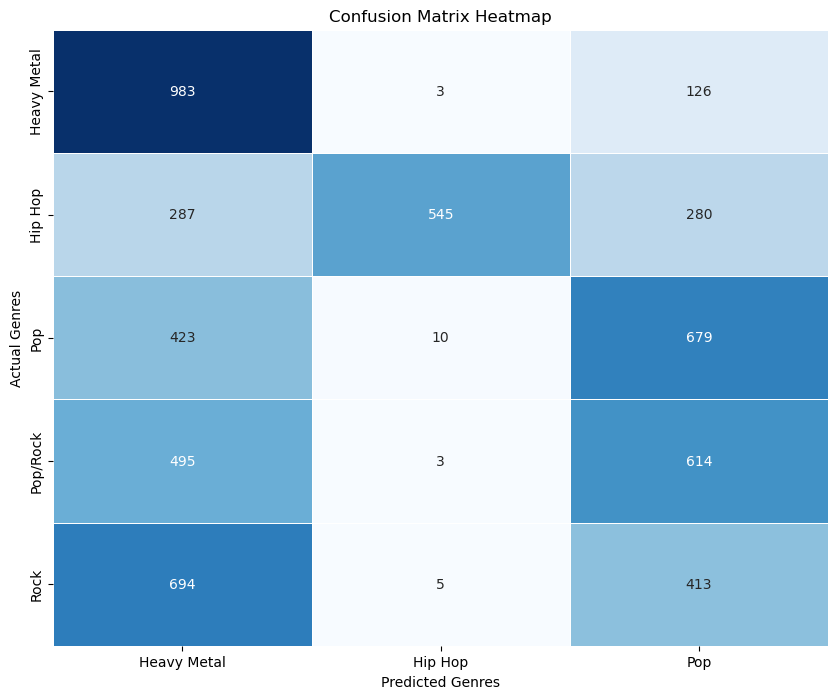

In [93]:
cluster_labels = {}
for i in range(n_clusters_adj):
    most_frequent_genre = df_balanced[df_balanced['Cluster'] == i]['Genres'].value_counts().idxmax()
    cluster_labels[i] = most_frequent_genre

# Map the clusters to the assigned labels
df_balanced['Predicted_Genres'] = df_balanced['Cluster'].map(cluster_labels)

# Create a Confusion Matrix
conf_matrix = pd.crosstab(df_balanced['Genres'], df_balanced['Predicted_Genres'], margins=True, margins_name="Total")

# Calculate Classification Metrics
print("Classification Report:")
print(classification_report(df_balanced['Genres'], df_balanced['Predicted_Genres']))

# Plot confusion matrix
conf_matrix_vis = conf_matrix.iloc[:-1, :-1]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_vis, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Genres")
plt.ylabel("Actual Genres")
plt.show()

In [90]:
print(accuracy_score(df_balanced['Genres'], df_balanced['Predicted_Genres']))

0.3969424460431655


### Observations
- Heavy Metal and Hip Hop genres have the highest precision, suggesting that when the model predicts these genres, it is usually correct.
- Pop/Rock and Rock genres have zero precision and recall, indicating that the model completely fails to recognize or correctly classify these genres.
- Pop and Pop/Rock genres, on the other hand, are spread across multiple clusters, indicating a potential overlap in lyrical content or a lack of distinct features to separate them.
- The accuracy, while improved from previous models, is still sub-optimal at around 39.69%.

This tuned K-Means model offers better performance than the initial K-Means and DBSCAN models. However, there's still substantial room for improvement, particularly in distinguishing between genres with similar lyrical content.

## 4.4 Conclusion

In this project, we delved into the intricacies of model selection and its implications on performance. Our initial hypothesis posited that unsupervised learning might not be the optimal choice for this particular classification task. The results obtained reinforced this notion. However, the insights gleaned from this project were invaluable.

We recognized the importance of aligning model selection with the context of the data. Textual data, especially something as nuanced as song lyrics, often requires a more context-aware approach. The labels associated with such data can provide crucial cues, making supervised learning or deep learning potentially more effective for tasks like genre classification.

In future endeavors, we intend to leverage the philosophy of supervised or deep learning models, aiming to harness both the context of the text and the available labels. This approach promises to build more robust and accurate models for classifying genres based on song lyrics.

# Reference
- https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres/data
- https://www.sciencedirect.com/science/article/abs/pii/S0020025522014633
- https://en.wikipedia.org/wiki/Silhouette_(clustering)
- https://en.wikipedia.org/wiki/K-means_clustering
- https://en.wikipedia.org/wiki/DBSCAN